In [87]:
import pandas_datareader as web
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf 
import math
import pandas_datareader as web

In [39]:
def profitability(stock, start, end):
    #We apply the previous function in order to get the sell and buy moments
    df = web.DataReader(stock, data_source="yahoo", start=start, end=end)
    #Calculate the On Balance Volume (OBV)
    OBV = []
    OBV.append(0)
    #Loop through the data set from the second row (index1) to the end of the data set
    for i in range(1, len(df.Close)):
        if df.Close[i] > df.Close[i-1]:
            OBV.append(OBV[-1] + df.Volume[i])
        elif df.Close[i] < df.Close[i-1]:
            OBV.append(OBV[-1] - df.Volume[i])
        else:
            OBV.append(OBV[-1])
    #Store the OBV and the Exponential Moving Average into new columns
    df["OBV"] = OBV
    df["OBV_EMA"] = df["OBV"].ewm(span=20).mean()
    def buy_sell(signal, col1, col2):
        sigPriceBuy = []
        sigPriceSell = []
        flag = -1
        #Loop through the lenght of the data set
        for i in range(0, len(signal)):
            #IF OBV > OBV_EMA then Buy
            if signal[col1][i] > signal[col2][i] and flag != 1:
                sigPriceBuy.append(signal["Close"][i])
                sigPriceSell.append(np.nan)
                flag = 1
            #If OBV < OBV_EMA then sell
            elif signal[col1][i] < signal[col2][i] and flag != 0:
                sigPriceSell.append(signal["Close"][i])
                sigPriceBuy.append(np.nan)
                flag = 0
            else:
                sigPriceSell.append(np.nan)
                sigPriceBuy.append(np.nan)
        return (sigPriceBuy, sigPriceSell)
    x = buy_sell(df, "OBV", "OBV_EMA")
    df["Buy_Signal_Price"] = x[0]
    df["Sell_Signal_Price"] = x[1]
    #Plot the result
    plt.figure(figsize=(12.2, 4.5))
    plt.plot(df["Close"], label = "Close", alpha = 0.35)
    plt.scatter(df.index, df["Buy_Signal_Price"], label = "Buy Signal", marker =  "^", alpha = 1, color = "green")
    plt.scatter(df.index, df["Sell_Signal_Price"], label = "Sell Signal", marker = "v", alpha = 1, color = "red")
    plt.title(f"{stock} Buy and Sell Signals")
    plt.xlabel("Date", fontsize = 18)
    plt.ylabel("Price USD", fontsize = 18)
    plt.legend(loc = "upper left")
    plt.show()
    #Then we create a new dataframe to analyze this moments
    measure = df[["Buy_Signal_Price", "Sell_Signal_Price"]]
    #We substitute Nans with 0s
    measure["Buy_0"] = measure["Buy_Signal_Price"].fillna(0)
    measure["Sell_0"] = measure["Sell_Signal_Price"]. fillna(0)
    #We find the money someone would end up with using the strategy starting with 10000
    money = 10000
    shares = 10000/df["Close"][0]
    for i in range(0, (len(measure["Buy_0"] + 1))):
    #for i in range(0, 17):
        if measure["Buy_0"][i] == 0 and measure["Sell_0"][i] == 0:
            pass
        elif measure["Buy_0"][i] != 0:
            shares = money/measure["Buy_0"][i]
        elif measure["Sell_0"][i] != 0:
            money = shares*measure["Sell_0"][i]
    #We find if the last movement is a sell or a purchase
    for i in range(0, (len(measure["Buy_0"] + 1))):
        if measure["Buy_0"][i] != 0:
            counter_buy = i
        if measure["Sell_0"][i] != 0:
            counter_sell = i
    #We calculate the money    
    if counter_sell > counter_buy:
        final_money = money
    else:
        final_money = shares*(df["Close"][-1])
    #We calculate the percentaje of profitability
    percentage = (final_money/10000) - 1
    #We calculate the real profitability of the stock without using OBV
    real_profitability = (df["Close"][-1]/df["Close"][0]) - 1 
    print((percentage, real_profitability))
    return (percentage, real_profitability)
#f"The profitability of this stock using OBV is {percentage} vs the profitability without using the method {real_profitability}"

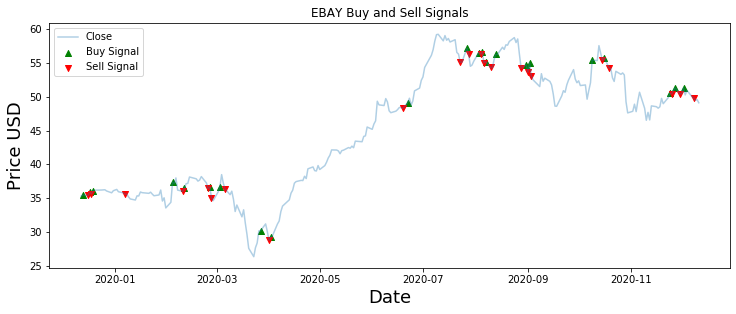

(0.2515758971143631, 0.3913905170583727)


<ipython-input-39-6a1cde26d340>:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  measure["Buy_0"] = measure["Buy_Signal_Price"].fillna(0)
<ipython-input-39-6a1cde26d340>:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  measure["Sell_0"] = measure["Sell_Signal_Price"]. fillna(0)


(0.2515758971143631, 0.3913905170583727)

In [92]:
profitability("EBAY", "2019-12-12", "2020-12-12")

We can observe that depending on the stock and the time frame selected we obtain a better performance with our OBV model or not. 

In order to see how reliable our model is, let´s try it with a big number of stocks

### IBEX 35

We start by gathering the codes of each one of the stocks that compose the index

In [32]:
ibex_codes = ["AENA.MC", "CLNX.MC", "NTGY.MC", "VIS.MC", "IBE.MC", "FER.MC", "REE.MC", "PHM.MC", "ACS.MC", "MAP.MC", "ACX.MC", "ELE.MC", "SGRE.MC", "ITX.MC", "GRF.MC", "MTS.MC", "AMS.MC", "COL.MC", "CABK.MC", "MRL.MC", "REP.MC", "BBVA.MC", "BKT.MC", "SAN.MC", "SAB.MC", "ANA.MC", "TEF.MC", "IAG.MC", "ENG.MC", "BKIA.MC", "CIE.MC", "ALM.MC", "SLR.MC", "IDR.MC", "MEL.MC"]

In [33]:
len(ibex_codes)

35

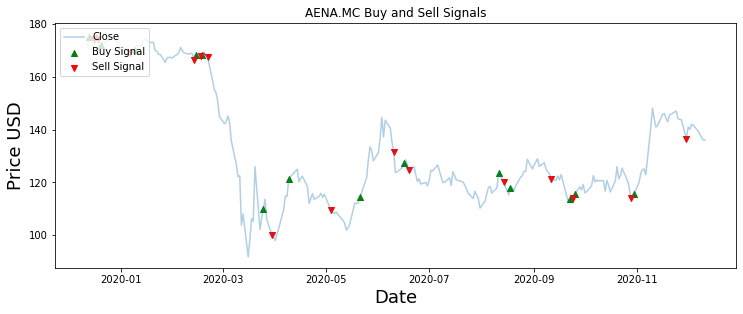

<ipython-input-39-6a1cde26d340>:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  measure["Buy_0"] = measure["Buy_Signal_Price"].fillna(0)
<ipython-input-39-6a1cde26d340>:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  measure["Sell_0"] = measure["Sell_Signal_Price"]. fillna(0)


(0.028190306889730454, -0.20595092794628622)


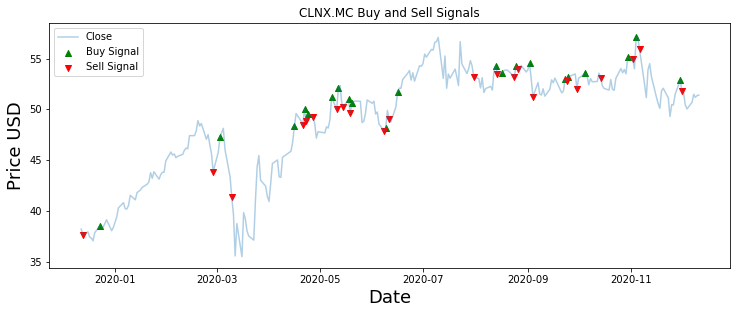

(-0.26686541674487085, 0.34519766441884725)


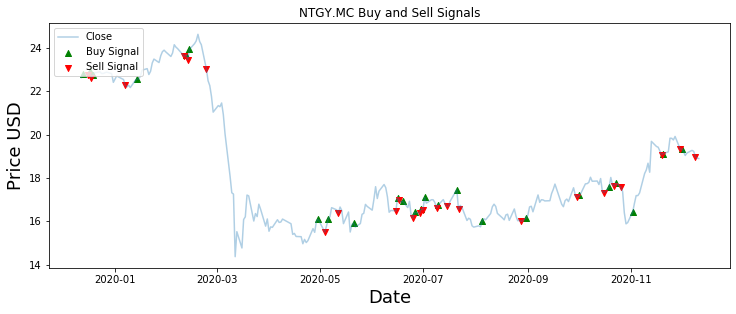

(0.03029067775999783, -0.1646772875007536)


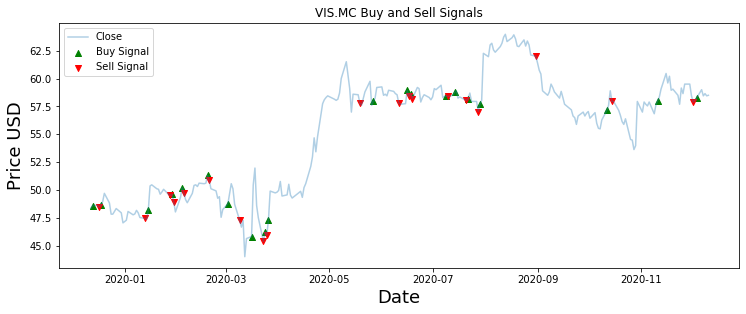

(0.1670283840244411, 0.20817848435028652)


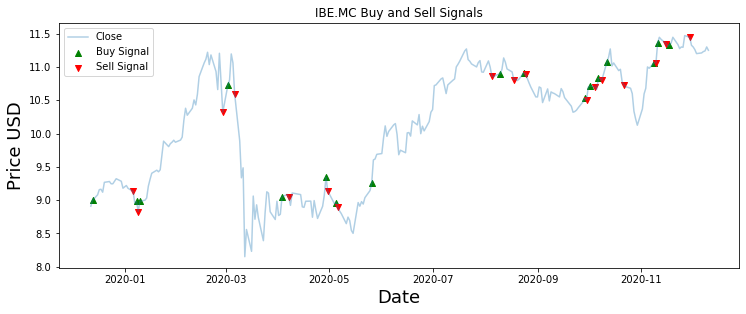

(0.24069552386174364, 0.26262628424932455)


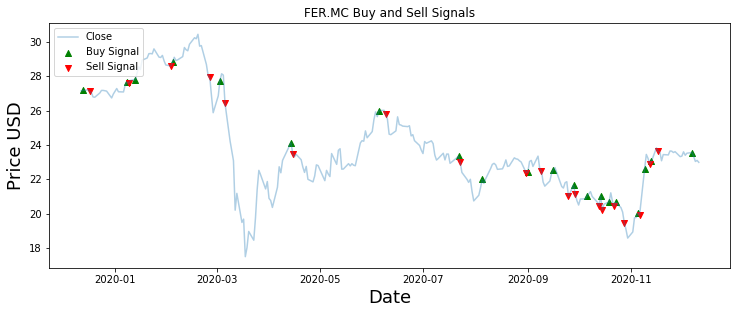

(-0.2686915082383524, -0.15353461339180663)


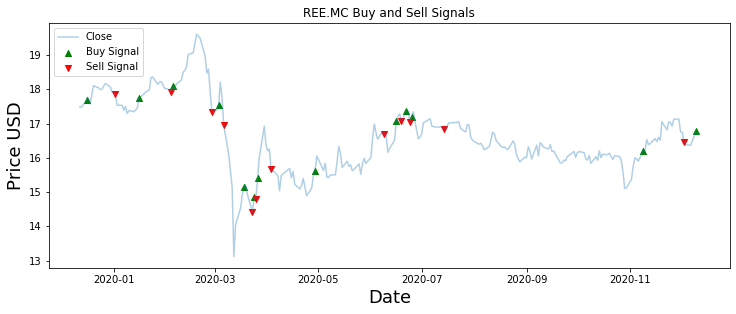

(-0.049127676533065046, -0.045181634998608056)


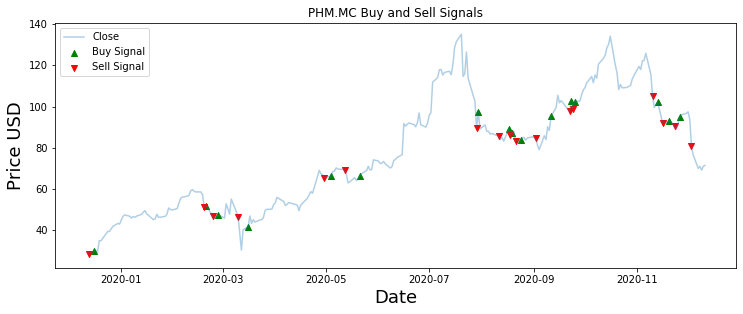

(1.0779112447129093, 1.466824083014191)


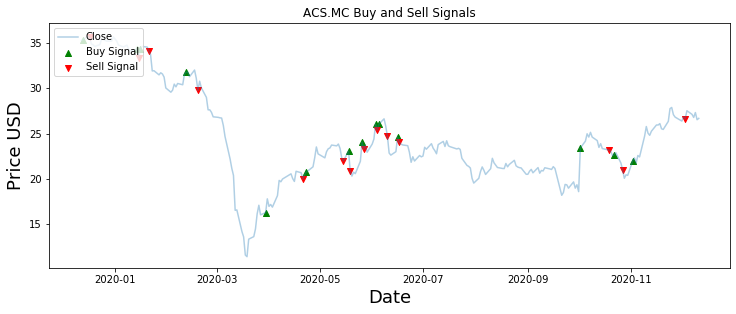

(0.0419411898925961, -0.24312055871841753)


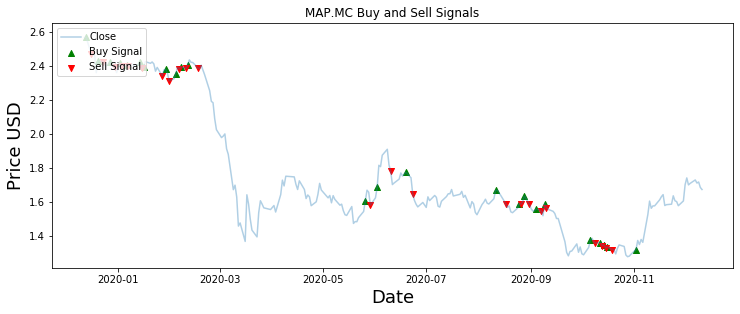

(-0.06869322534865496, -0.3476227456157369)


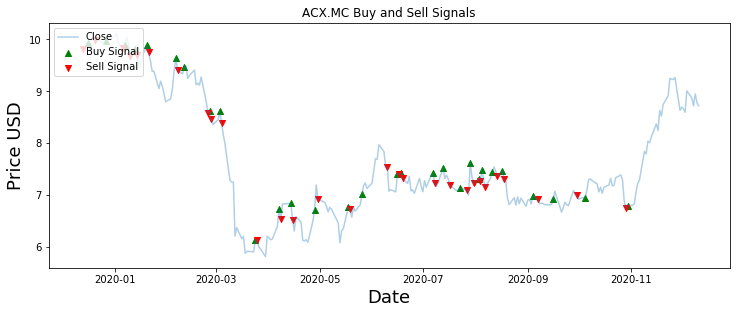

(-0.1864634228495814, -0.111970718782481)


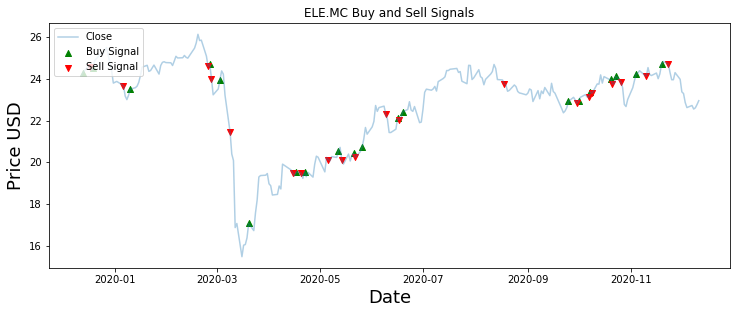

(0.12679008117574098, -0.049295719005662986)


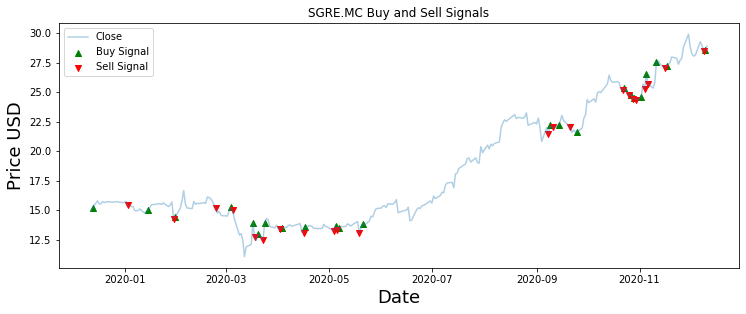

(0.32605949474921037, 0.9383377968103557)


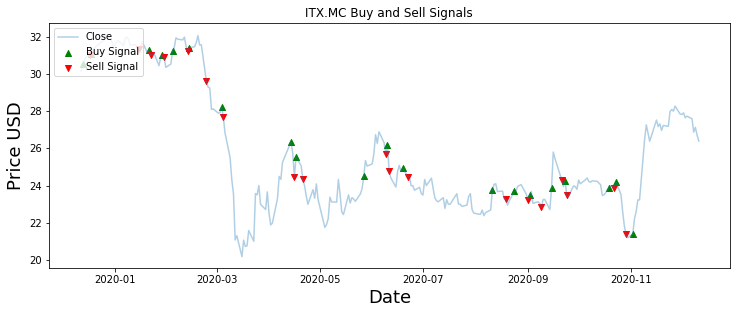

(-0.18911153152996052, -0.12466844323291548)


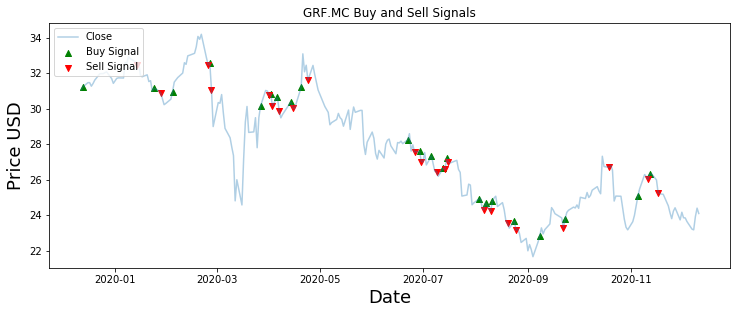

(-0.06440455821067459, -0.22401027205777813)


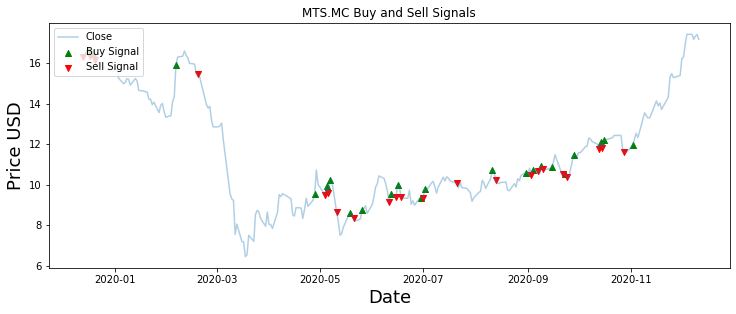

(-0.10716721615902147, 0.05381222482351822)


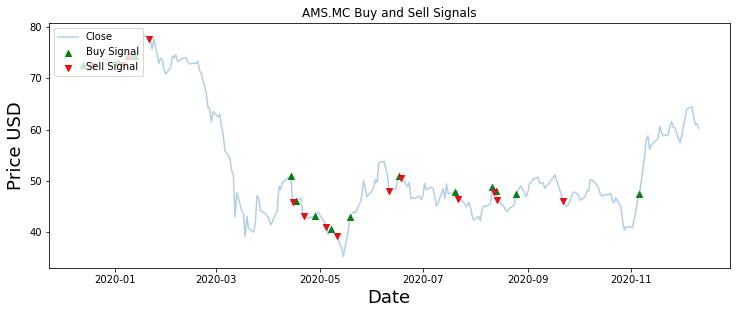

(-0.0010631632974400507, -0.15799770627448395)


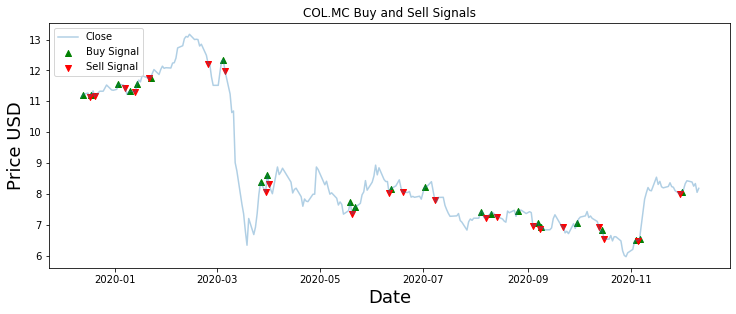

(-0.10575898202682932, -0.2641509886637857)


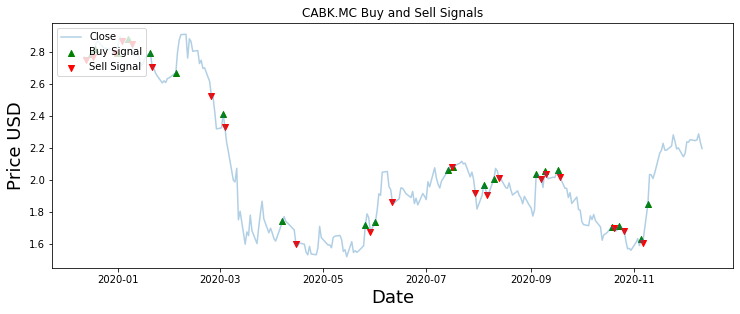

(-0.16383773696868942, -0.20764238999934592)


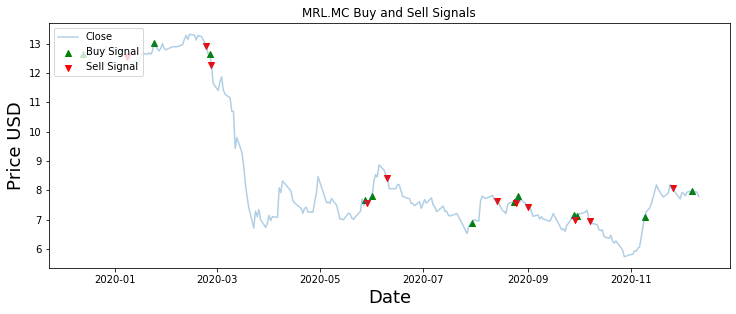

(0.13135652473305082, -0.38165212445911745)


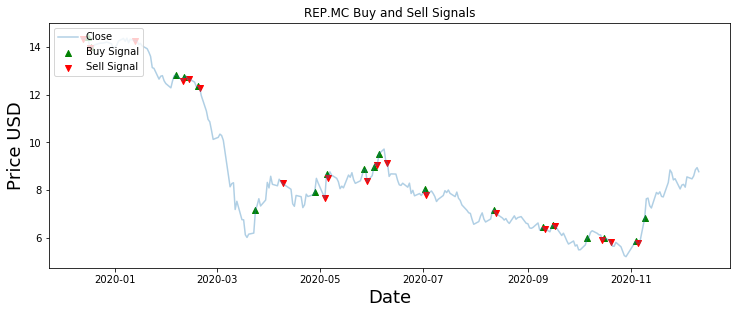

(0.0879014470322026, -0.389217409880265)


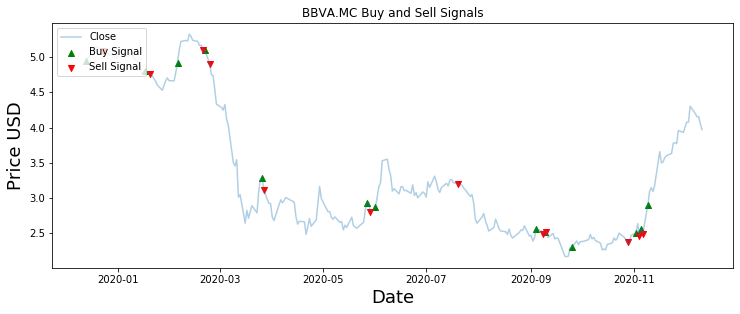

(0.3452617825162092, -0.19305020259038563)


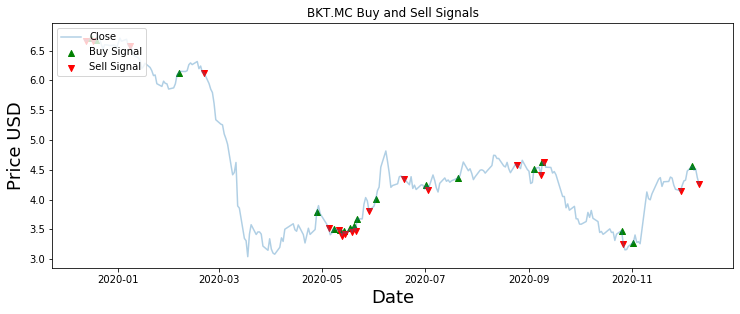

(0.030752585361291773, -0.36182632919253555)


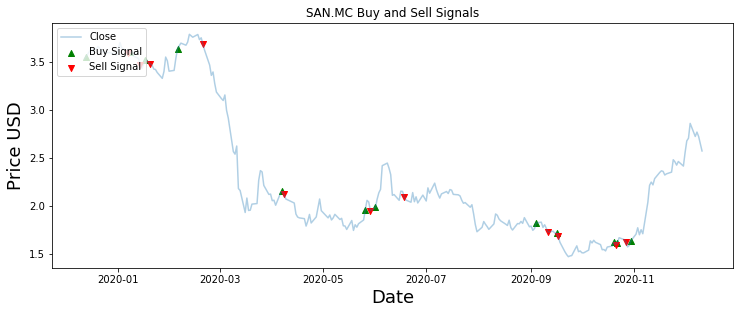

(0.45379989573715296, -0.27143189035873727)


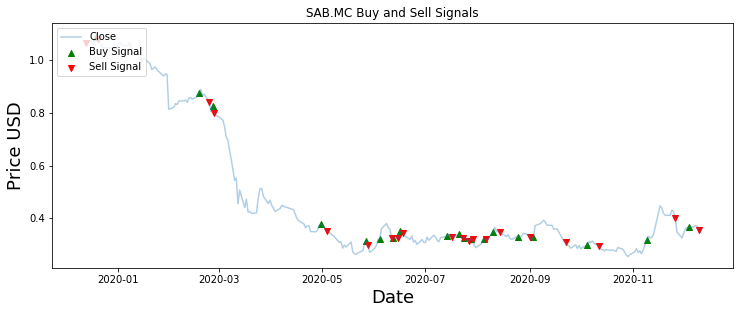

(-0.16219199461965728, -0.6758583105902185)


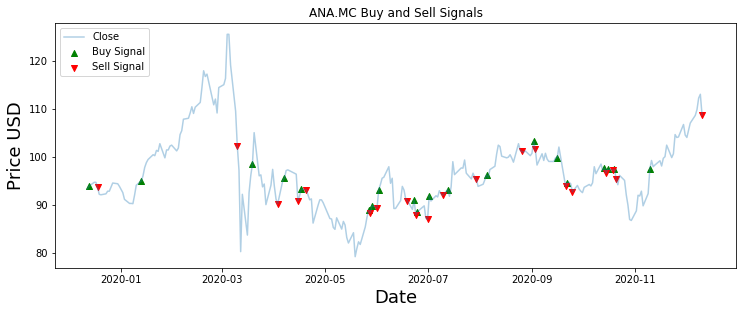

(-0.10093766759271061, 0.16505887880776693)


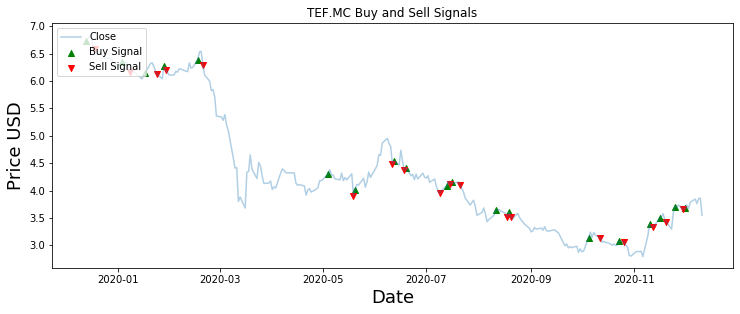

(-0.3082216981572711, -0.4698938917963631)


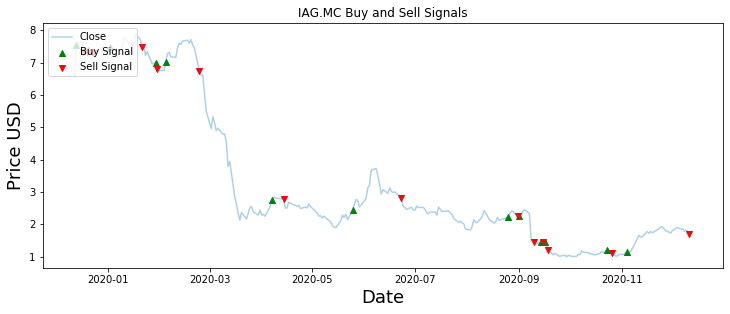

(-0.2289627175517509, -0.7399543404845115)


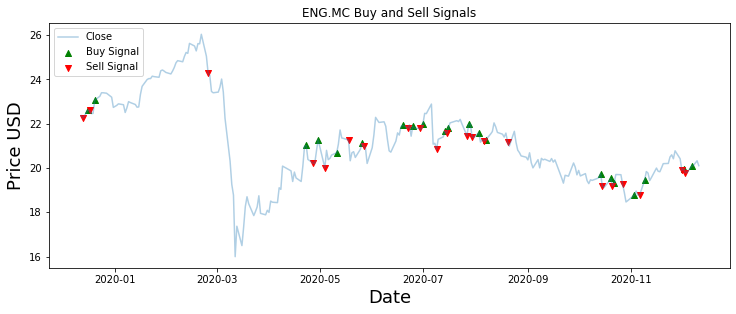

(-0.180432860759982, -0.10102816915939306)


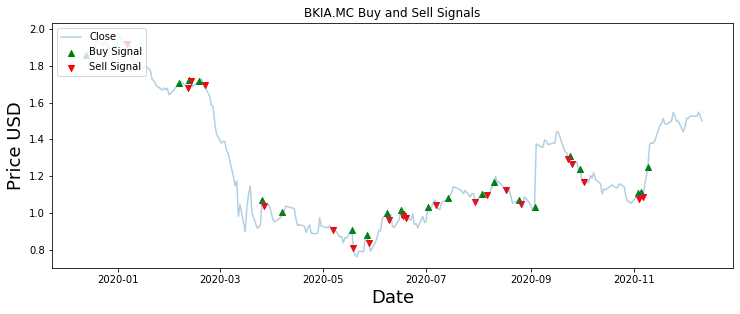

(-0.19977716564793713, -0.19181032157220612)


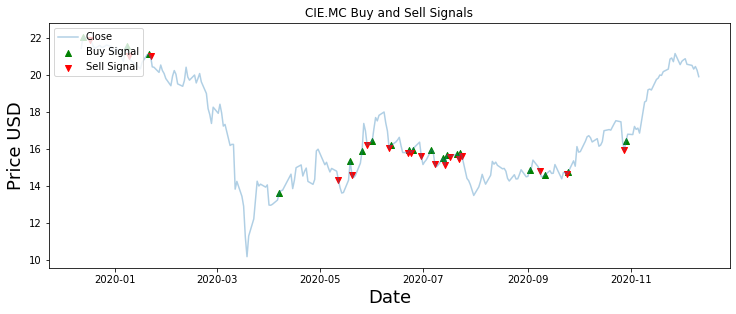

(0.06890220574471484, -0.07136197054729965)


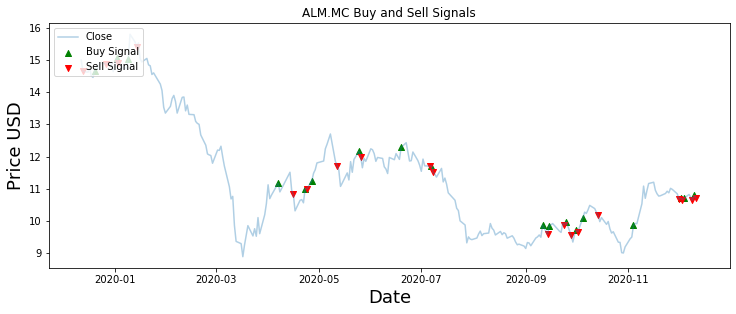

(-0.06671237809366992, -0.28599999745686844)


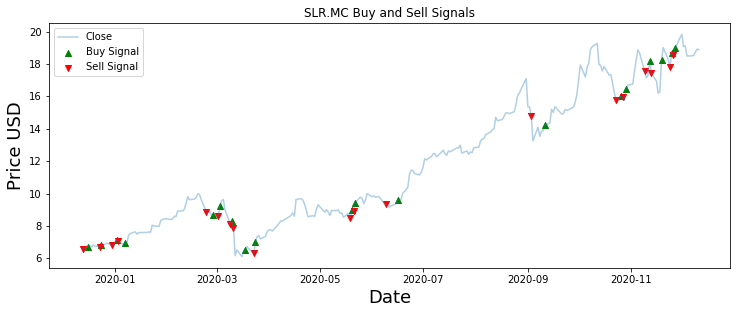

(1.0793027256399426, 1.8299623745132512)


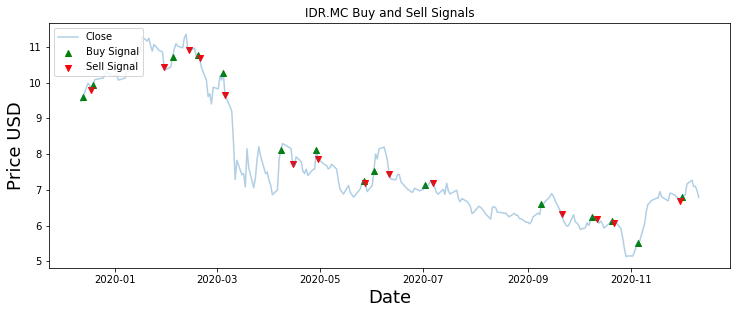

(0.0644049340440287, -0.28375524370001504)


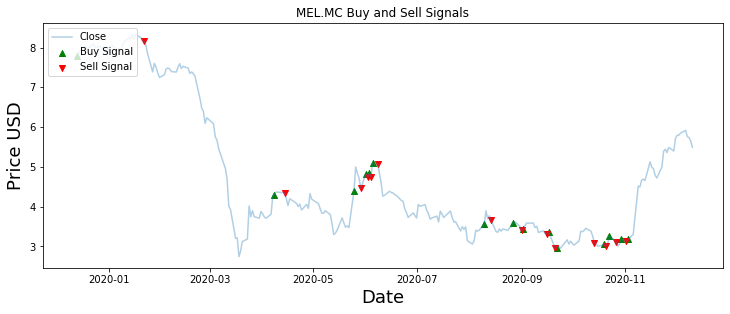

(0.4267445948752875, -0.2909677567020539)


In [43]:
profitabilities = []
for code in ibex_codes:
    a = profitability(code, "2019-12-12", "2020-12-12")
    profitabilities.append(a)

In [44]:
profitabilities

[(0.028190306889730454, -0.20595092794628622),
 (-0.26686541674487085, 0.34519766441884725),
 (0.03029067775999783, -0.1646772875007536),
 (0.1670283840244411, 0.20817848435028652),
 (0.24069552386174364, 0.26262628424932455),
 (-0.2686915082383524, -0.15353461339180663),
 (-0.049127676533065046, -0.045181634998608056),
 (1.0779112447129093, 1.466824083014191),
 (0.0419411898925961, -0.24312055871841753),
 (-0.06869322534865496, -0.3476227456157369),
 (-0.1864634228495814, -0.111970718782481),
 (0.12679008117574098, -0.049295719005662986),
 (0.32605949474921037, 0.9383377968103557),
 (-0.18911153152996052, -0.12466844323291548),
 (-0.06440455821067459, -0.22401027205777813),
 (-0.10716721615902147, 0.05381222482351822),
 (-0.0010631632974400507, -0.15799770627448395),
 (-0.10575898202682932, -0.2641509886637857),
 (-0.16383773696868942, -0.20764238999934592),
 (0.13135652473305082, -0.38165212445911745),
 (0.0879014470322026, -0.389217409880265),
 (0.3452617825162092, -0.19305020259038

In [47]:
success_fail = []
for i in profitabilities:
    if i[0] > i[1]:
        success_fail.append("S")
    elif i[0] < i[1]:
        success_fail.append("F")
    else:
        success_fail.append("NaN")

In [70]:
df = pd.DataFrame(np.array(success_fail), columns = ["Success"])

In [74]:
df.Success.value_counts()

S    21
F    14
Name: Success, dtype: int64

In [75]:
profitabilities_OBV = []
profitabilities_real = []
for i in profitabilities: 
    profitabilities_OBV.append(i[0])
    profitabilities_real.append(i[1])

In [76]:
df["Profitabilities_OBV"] = profitabilities_OBV

In [77]:
df["Profitabilities_real"] = profitabilities_real

In [78]:
df

,Success,Profitabilities_OBV,Profitabilities_real
0,S,0.028190,-0.205951
1,F,-0.266865,0.345198
2,S,0.030291,-0.164677
3,F,0.167028,0.208178
4,F,0.240696,0.262626
5,F,-0.268692,-0.153535
6,F,-0.049128,-0.045182
7,F,1.077911,1.466824
8,S,0.041941,-0.243121
9,S,-0.068693,-0.347623


In [79]:
df["Company"] = ibex_codes

In [80]:
df

,Success,Profitabilities_OBV,Profitabilities_real,Company
0,S,0.028190,-0.205951,AENA.MC
1,F,-0.266865,0.345198,CLNX.MC
2,S,0.030291,-0.164677,NTGY.MC
3,F,0.167028,0.208178,VIS.MC
4,F,0.240696,0.262626,IBE.MC
5,F,-0.268692,-0.153535,FER.MC
6,F,-0.049128,-0.045182,REE.MC
7,F,1.077911,1.466824,PHM.MC
8,S,0.041941,-0.243121,ACS.MC
9,S,-0.068693,-0.347623,MAP.MC


In [83]:
df["Percentage Value"] = (df["Profitabilities_OBV"] + 10) - (df["Profitabilities_real"] + 10)

In [84]:
df

,Success,Profitabilities_OBV,Profitabilities_real,Company,Percentage Value
0,S,0.028190,-0.205951,AENA.MC,0.234141
1,F,-0.266865,0.345198,CLNX.MC,-0.612063
2,S,0.030291,-0.164677,NTGY.MC,0.194968
3,F,0.167028,0.208178,VIS.MC,-0.041150
4,F,0.240696,0.262626,IBE.MC,-0.021931
5,F,-0.268692,-0.153535,FER.MC,-0.115157
6,F,-0.049128,-0.045182,REE.MC,-0.003946
7,F,1.077911,1.466824,PHM.MC,-0.388913
8,S,0.041941,-0.243121,ACS.MC,0.285062
9,S,-0.068693,-0.347623,MAP.MC,0.278930


In [85]:
df["Percentage Value"].mean()

0.10704419577458917

This value means, that using OBV I would´ve gotten a 10% higher return of my investment vs buying every single stock at the beginning of the year and selling it today